# Cell segmentation training 

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Selecting central slice
- Save images as tif
----

### Libraries

In [1]:
# Importing libraries
import sys
import matplotlib.pyplot as plt 
import numpy as np 
import tifffile
import shutil
import zipfile
import os
import seaborn as sns
import pandas as pd
import pathlib
import warnings
import imageio
from skimage import io
from cellpose import models
from cellpose import plot
from skimage.morphology import erosion, disk, square
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
# creating directories

# Directories for images
DAPI_folder_path = current_dir.joinpath('DAPI')
CYTO_folder_path = current_dir.joinpath('CYTO')
if not DAPI_folder_path.exists():  
    DAPI_folder_path.mkdir(parents=False, exist_ok=True)
if not CYTO_folder_path.exists():  
    CYTO_folder_path.mkdir(parents=False, exist_ok=True)
    
# Directories for masks
DAPI_masks_folder_path = current_dir.joinpath('DAPI_masks')
CYTO_masks_folder_path = current_dir.joinpath('CYTO_masks')
if not DAPI_masks_folder_path.exists():  
    DAPI_masks_folder_path.mkdir(parents=False, exist_ok=True)
if not CYTO_masks_folder_path.exists():  
    CYTO_masks_folder_path.mkdir(parents=False, exist_ok=True)
    
# Directories for binary images
DAPI_masks_binary_folder_path = current_dir.joinpath('DAPI_masks_binary')
CYTO_masks_binary_folder_path = current_dir.joinpath('CYTO_masks_binary')
if not DAPI_masks_binary_folder_path.exists():  
    DAPI_masks_binary_folder_path.mkdir(parents=False, exist_ok=True)
if not CYTO_masks_binary_folder_path.exists():  
    CYTO_masks_binary_folder_path.mkdir(parents=False, exist_ok=True)



----

# Parameters defined by the user 

----

### Paths to images

In [4]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')
# Path to images and masks
data_folder_path =pathlib.Path('/home/luisub/Desktop/FISH_Processing/dataBases/DUSP1_Dex_0min_20220125')


In [5]:
# loading imges
local_data_dir, masks_dir, number_images, number_color_channels, list_files_names, list_images = fa.Utilities().read_images_from_folder( path_to_config_file, data_folder_path)


Image shape:  (27, 936, 640, 3) 

Number of images:  20 

Local directory with images:  /home/luisub/Desktop/FISH_Processing/dataBases/DUSP1_Dex_0min_20220125 



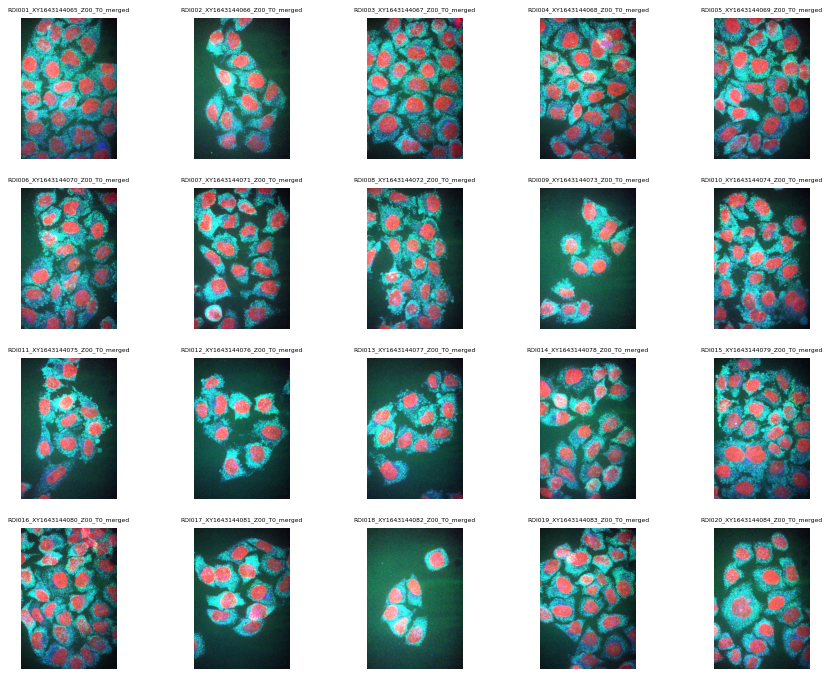

In [6]:
# plot one image
#fa.Plots().plot_images(image=list_images[0],figsize=(8.5, 5),image_name='temp',show_plots=True)
fa.Plots().plotting_all_original_images(list_images=list_images,list_files_names=list_files_names,image_name='temp.png',show_plots=True)

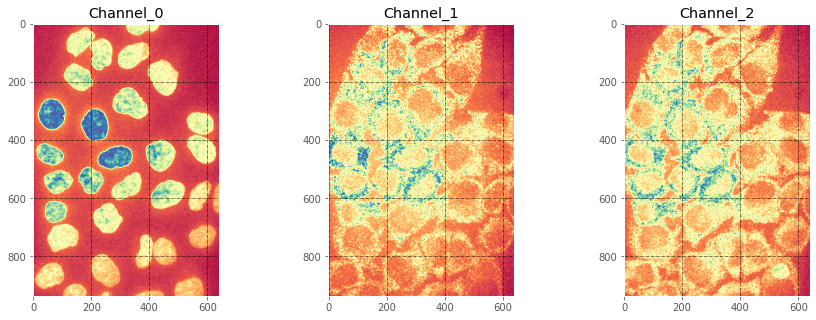

In [7]:
fa.Plots().plot_images(image=list_images[0],figsize=(15, 5),image_name='temp',show_plots=True,use_maximum_projection=True)


In [8]:
# Image selection
def image_selection (image,use_maximum_projection=True,convert_to_uint_8=True):
    number_color_channels = image.shape[-1]
    number_z_slices = image.shape[0]
    complete_image = np.zeros_like(image[0,:,:,:])
    if number_z_slices ==1:
        center_slice =0
    else:
        center_slice = image.shape[0]//2
    for i in range (0,number_color_channels ):
        if number_z_slices >1:
            if use_maximum_projection == True:
                temp_max = np.max(image[:,:,:,i],axis =0)
                rescaled_image = fa.RemoveExtrema(temp_max,min_percentile=1, max_percentile=98).remove_outliers() 
            else:
                rescaled_image = fa.RemoveExtrema(image[center_slice,:,:,i],min_percentile=1, max_percentile=98).remove_outliers() 
        else:
            rescaled_image = fa.RemoveExtrema(image[center_slice,:,:,i],min_percentile=1, max_percentile=98).remove_outliers() #image
        complete_image[:,:,i] = rescaled_image
    if convert_to_uint_8 == True:
        return fa.Utilities().convert_to_int8(complete_image,rescale=False)
    else:
        return complete_image
    

In [9]:
# Section that read each image gets the maximum projection and saves the image as png
list_dapi_paths =[]
list_cyto_paths =[]
list_dapi_images = []
list_cyto_images = []
for i, name in enumerate(list_files_names):
    temp_name = name[:-18]+'.tif'
    rescaled_image = image_selection(list_images[i])
    dapi_name = str(DAPI_folder_path.joinpath(temp_name))
    cyto_name = str(CYTO_folder_path.joinpath(temp_name))
    nucleus_image = rescaled_image[:,:,0]
    cyto_image = rescaled_image[:,:,2]
    io.imsave(dapi_name, nucleus_image)
    io.imsave(cyto_name, cyto_image)
    list_dapi_paths.append(dapi_name)
    list_cyto_paths.append(cyto_name)
    list_dapi_images.append(nucleus_image)
    list_cyto_images.append(cyto_image)


In [10]:
def saving_image_to_folder(image,path_name,name,save_as_uint8=True):
    temp_name = name[:-18]+'_masks'+'.tif'
    image_name = str(path_name.joinpath(temp_name))
    if save_as_uint8 == True:
        image = image.astype(np.uint8)
    #io.imsave(image_name, image)
    imageio.imwrite(image_name, image)

In [11]:
def saving_image_as_npy(image,path_name,name):
    temp_name = name[:-18]+'_seg.npy'
    image_name = str(path_name.joinpath(temp_name))
    np.save(image_name, image)

In [12]:
# Function that reorder the index to make it continuos 
def reorder_masks(mask_tested):
    n_mask_0 = np.max(mask_tested)
    mask_new =np.zeros_like(mask_tested)
    if n_mask_0>0:
        counter = 0
        for ind_0 in range(1,n_mask_0+1):
            if ind_0 in mask_tested:
                counter = counter + 1
                if counter ==1:
                    mask_new = np.where(mask_tested == ind_0, -counter, mask_tested)
                else:
                    mask_new = np.where(mask_new == ind_0, -counter, mask_new)
        reordered_mask = np.absolute(mask_new)
    else:
        reordered_mask = mask_new
    return reordered_mask  

In [13]:
# function to erode a mask cell by cell
def removing_borders(masks,mask_min_size =5000):
    new_mask = np.zeros_like(masks)
    counter = 0
    num_masks = np.max(masks)
    for i in range (1, num_masks+1):
        eroded_mask = erosion(np.where(masks == i, 1, 0),square(4))
        mask_size = np.sum(eroded_mask[eroded_mask != 0])
        if mask_size < mask_min_size:
            eroded_mask = np.zeros_like(masks)
        eroded_mask_with_cell_id = np.where(eroded_mask == 1, i, 0)
        new_mask = new_mask+ eroded_mask_with_cell_id
    return reorder_masks(new_mask)

In [14]:
# function that test if a cytosol has a nucleus
def is_nucleus_in_cytosol(mask_n, mask_c):
    mask_n[mask_n>1]=1
    mask_c[mask_c>1]=1
    size_mask_n = np.count_nonzero(mask_n)
    size_mask_c = np.count_nonzero(mask_c)
    min_size =np.min( (size_mask_n,size_mask_c) )
    mask_combined =  mask_n + mask_c
    sum_mask = np.count_nonzero(mask_combined[mask_combined==2])
    if (sum_mask> min_size*0.8) and (min_size>200): # the element is inside if the two masks overlap over the 80% of the smaller mask.
        return 1
    else:
        return 0

In [15]:
# Function that removes segmented cells without nucleus
def remove_lonely_masks(masks_0, masks_1,is_nuc=None):
    n_mask_0 = np.max(masks_0)
    n_mask_1 = np.max(masks_1)
    if (n_mask_0>0) and (n_mask_1>0):
        for ind_0 in range(1,n_mask_0+1):
            tested_mask_0 = erosion(np.where(masks_0 == ind_0, 1, 0))
            array_paired= np.zeros(n_mask_1)
            for ind_1 in range(1,n_mask_1+1):
                tested_mask_1 = erosion(np.where(masks_1 == ind_1, 1, 0))
                array_paired[ind_1-1] = is_nucleus_in_cytosol(tested_mask_1, tested_mask_0)
                if (is_nuc =='nuc') and (np.count_nonzero(tested_mask_0) > np.count_nonzero(tested_mask_1) ):
                    # condition that rejects images with nucleus bigger than the cytosol
                    array_paired[ind_1-1] = 0
                elif (is_nuc is None ) and (np.count_nonzero(tested_mask_1) > np.count_nonzero(tested_mask_0) ):
                    array_paired[ind_1-1] = 0
            if any (array_paired) == False: # If the cytosol is not associated with any mask.
                masks_0 = np.where(masks_0 == ind_0, 0, masks_0)
            masks_with_pairs = masks_0
    else:
        masks_with_pairs = np.zeros_like(masks_0)
    return masks_with_pairs

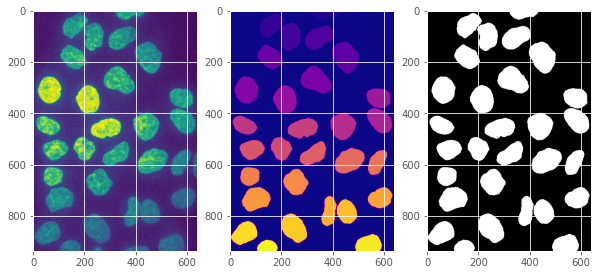

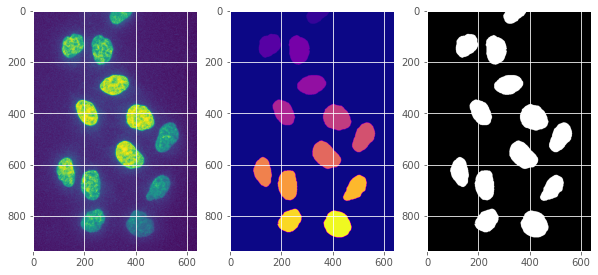

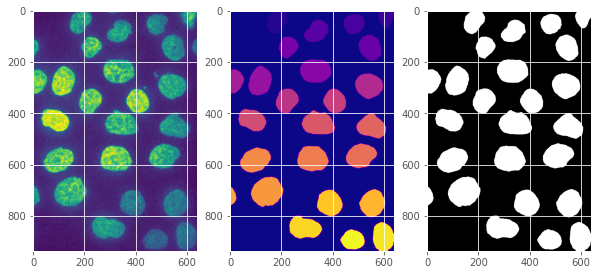

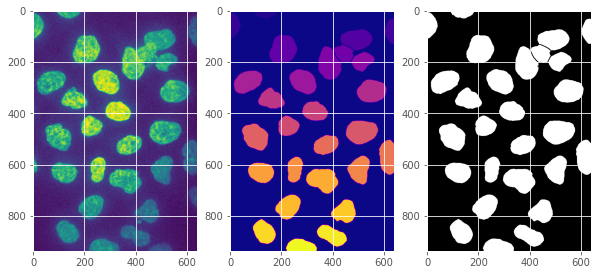

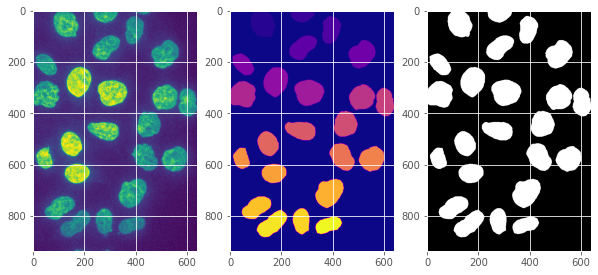

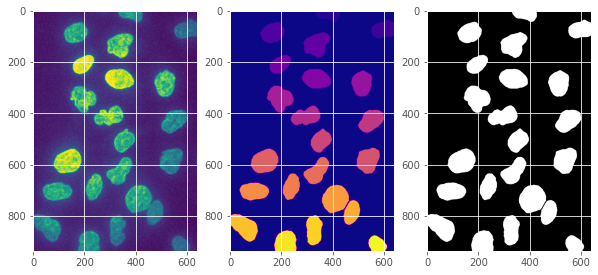

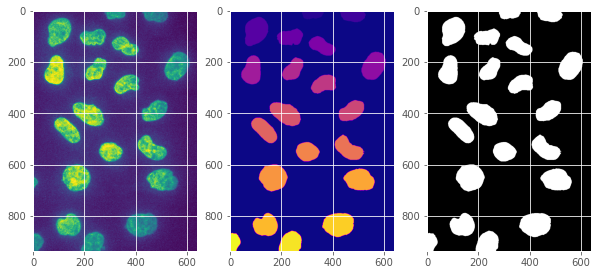

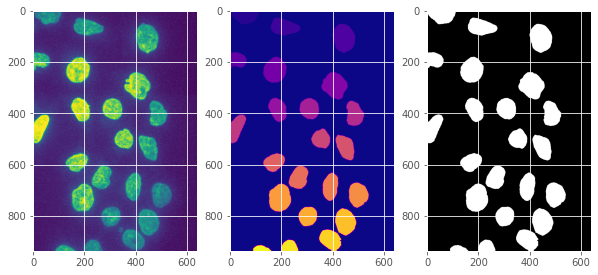

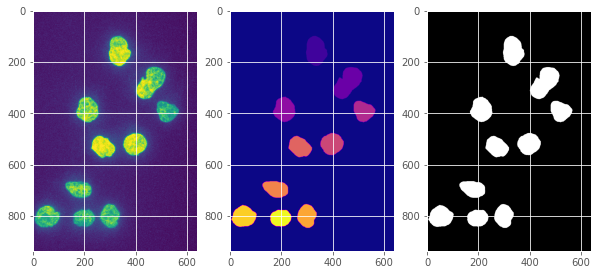

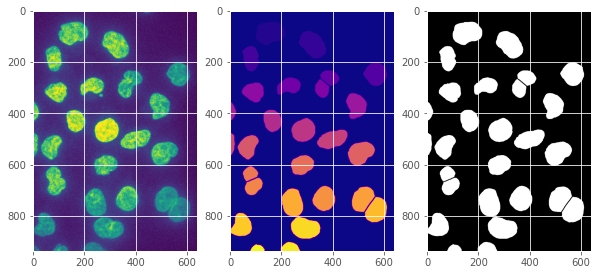

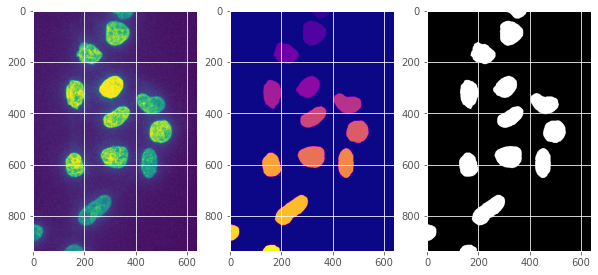

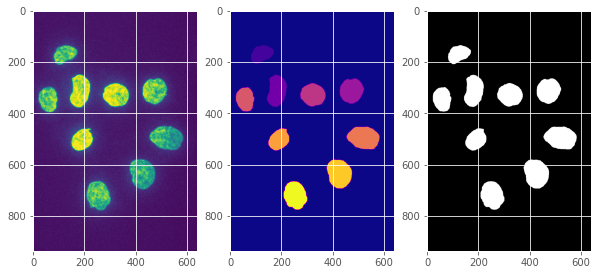

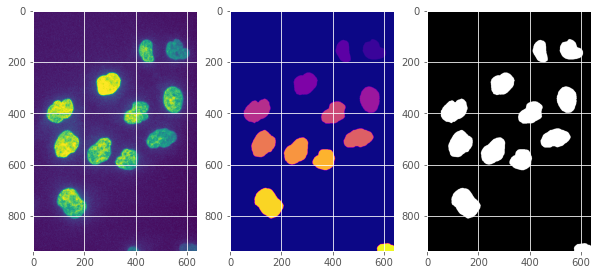

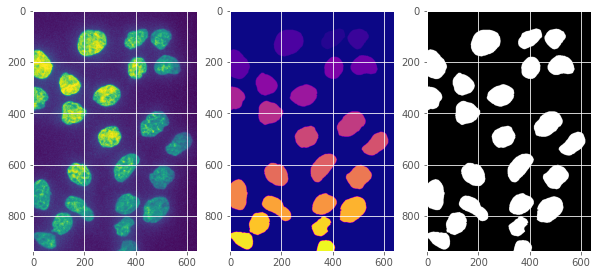

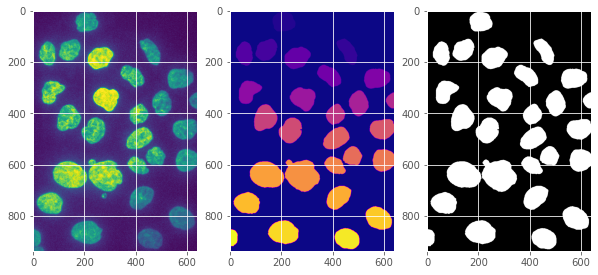

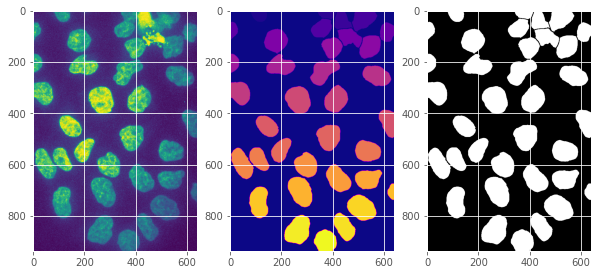

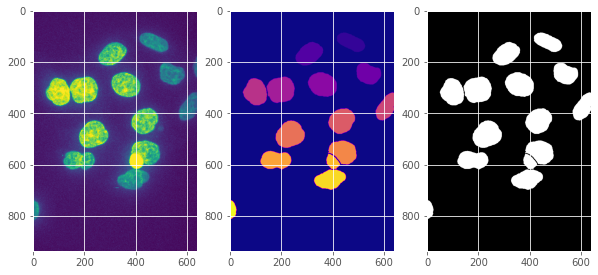

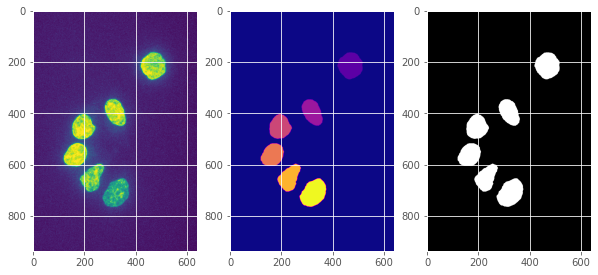

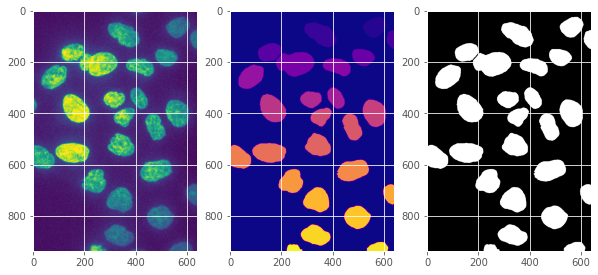

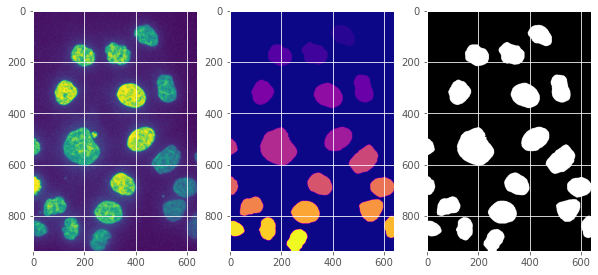

In [16]:
# Dapi segmentation

list_masks_nuc = []
for i, image in enumerate(list_dapi_images):
        _, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
        model = models.Cellpose(gpu=True, model_type='nuclei') # model_type='cyto', 'cyto2' or model_type='nuclei'
        masks = model.eval(image, diameter=100, flow_threshold=1, channels=[0,0], net_avg=True, augment=True)[0]
        masks = removing_borders(masks,mask_min_size=1000)
        # mask binarization
        mask_binary = masks.copy()
        mask_binary[mask_binary>0]=1
        axes[0].imshow(image)
        axes[1].imshow(masks,cmap ='plasma')
        axes[2].imshow(mask_binary,cmap ='Greys_r')
        plt.show()
        list_masks_nuc.append(masks)
        # saving masks as npy
        saving_image_as_npy(image=masks,path_name=DAPI_masks_folder_path,name=list_files_names[i])
        # saving masks as pngs
        saving_image_to_folder(image=masks,path_name=DAPI_masks_folder_path,name=list_files_names[i] ,save_as_uint8=True)
        saving_image_to_folder(image=mask_binary,path_name=DAPI_masks_binary_folder_path,name=list_files_names[i],save_as_uint8=True )

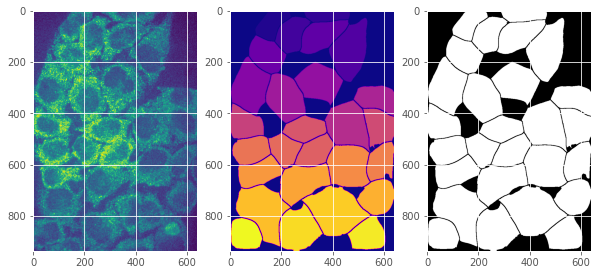

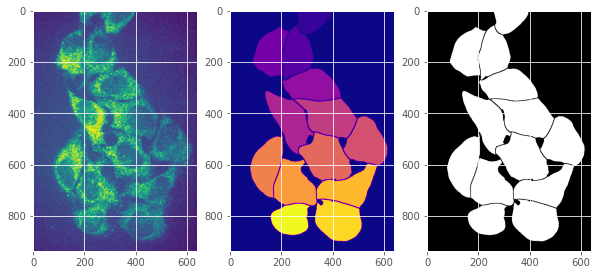

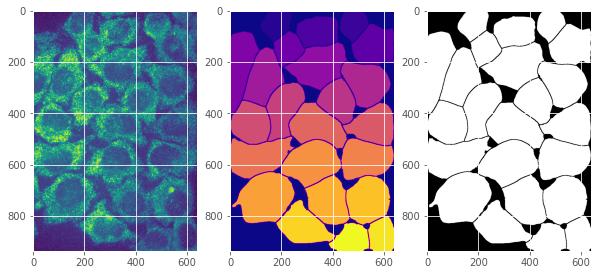

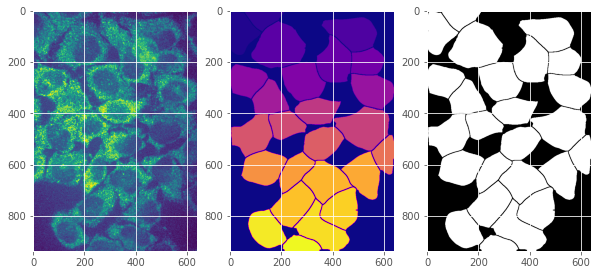

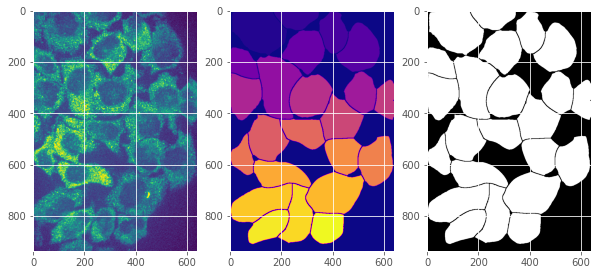

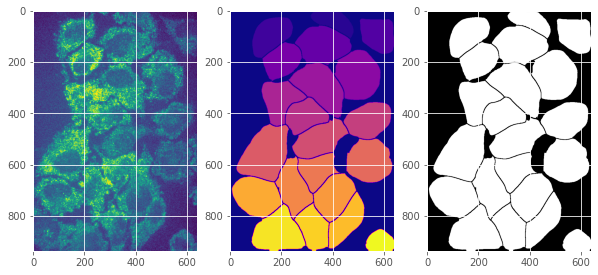

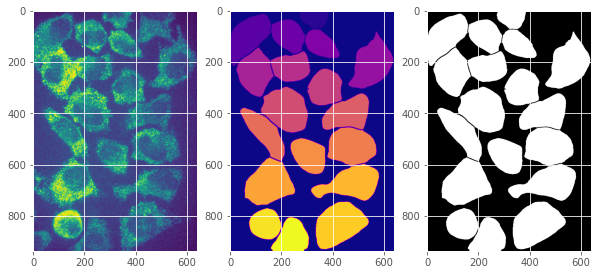

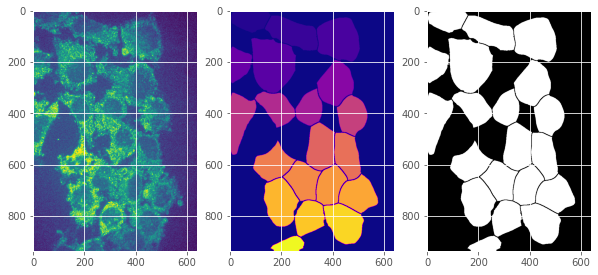

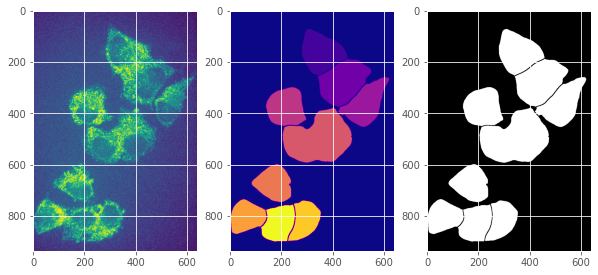

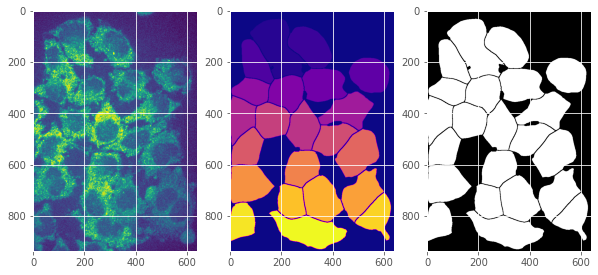

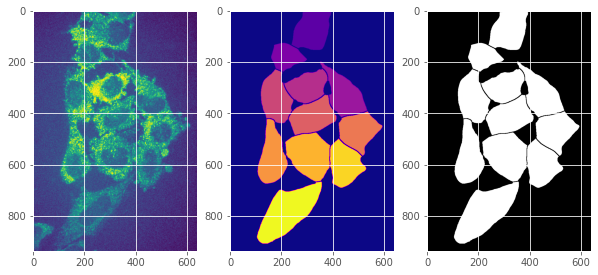

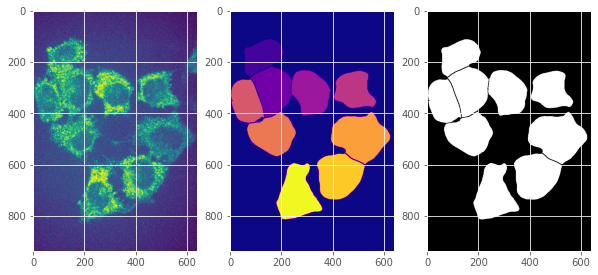

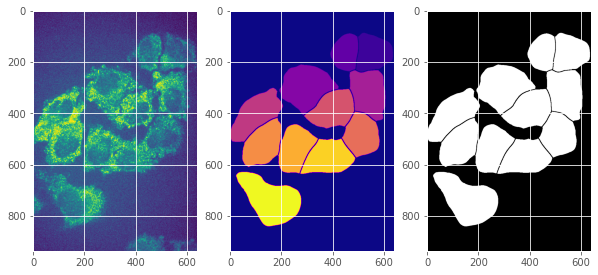

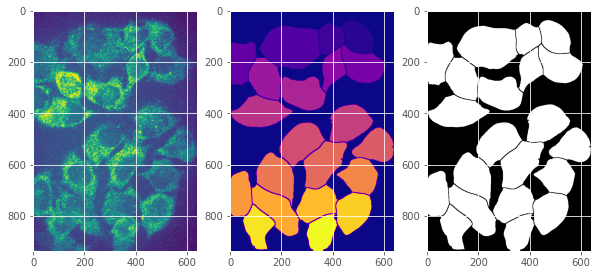

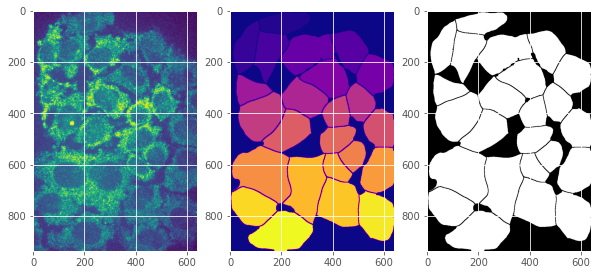

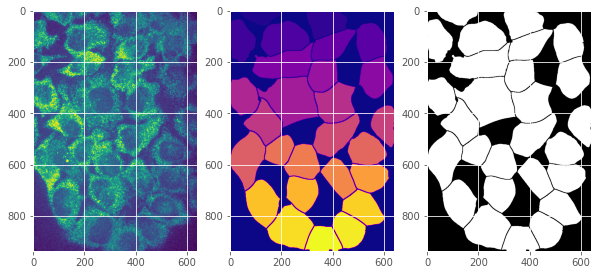

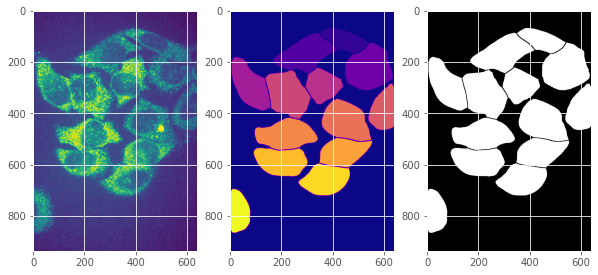

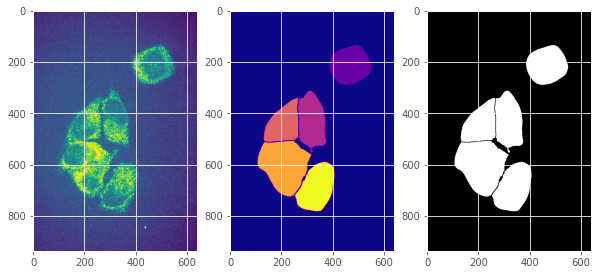

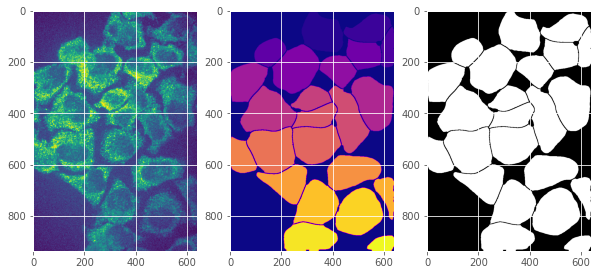

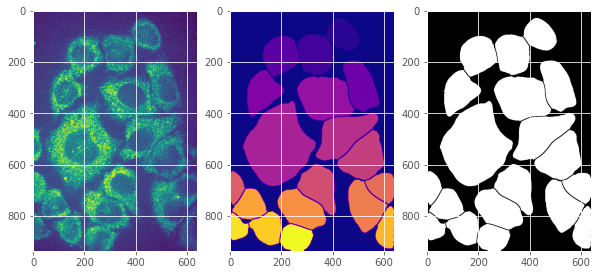

In [17]:
# Cyto segmentation
list_masks_cyto=[]
for i, image in enumerate(list_cyto_images):
    _, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
    model = models.Cellpose(gpu=True, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
    masks = model.eval(image, diameter=180, flow_threshold=0.6, channels=[0,0], net_avg=True, augment=True)[0]
    # removing mask if less than a size
    masks = removing_borders(masks,mask_min_size=5000)
    # removing mask if no nucleus is detected
    masks = remove_lonely_masks(masks_0=masks, masks_1=list_masks_nuc[i],is_nuc=None)
    # mask binarization
    mask_binary = masks.copy()
    mask_binary[mask_binary>0]=1
    axes[0].imshow(image)
    axes[1].imshow(masks,cmap ='plasma')
    axes[2].imshow(mask_binary,cmap ='Greys_r')
    plt.show()
    list_masks_cyto.append(masks)
    # saving masks
    saving_image_as_npy (image=masks,path_name=CYTO_masks_folder_path,name=list_files_names[i])
    saving_image_to_folder(image=masks,path_name=CYTO_masks_folder_path,name=list_files_names[i] ,save_as_uint8=True)
    saving_image_to_folder(image=mask_binary,path_name=CYTO_masks_binary_folder_path,name=list_files_names[i],save_as_uint8=True )

In [18]:
# convert masks to coco format
# follow this tutorial
# https://www.youtube.com/watch?v=NYeJvxe5nYw
